In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u



plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)




In [3]:
def make_masks(sess):
    trial_masks = {'left': None, 
                   'right': None, }
        # 'channel_0_left': None,
        #        'channel_0_right': None,
        #        'channel_1_left': None,
        #        'channel_1_right': None}
    left_mask = sess.trial_info['LR']==-1
    trial_masks['left'] = left_mask
    trial_masks['right'] = ~left_mask
    # trial_masks['channel_0_left'] = left_mask
    # trial_masks['channel_0_right'] = ~left_mask
    # trial_masks['channel_1_left'] = left_mask
    # trial_masks['channel_1_right'] = ~left_mask

    return trial_masks

In [4]:
def get_field_info(shuff_thresh, trial_means):
    field_info = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

    for k, thresh in shuff_thresh.items():
        
        sig_bins = trial_means[k]>thresh
    
        # eliminate fields that start at first bin of track or end at last bin of track
        
    
        ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
        
        for _ledge in ledges:
    
            rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
            _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
            # print(_redge.size)
            if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0):
                field_info[k].append([_ledge[1], _ledge[0], _redge[0][0]])
    
    
    for k,v in field_info.items():
        field_info[k]=np.array(v)

    return field_info

In [7]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice
# sparse_mice[3:4]
sparse_mice

('SparseKO_02',
 'SparseKO_06',
 'SparseKO_08',
 'SparseKO_10',
 'SparseKO_11',
 'SparseKO_13',
 'SparseKO_09')

In [10]:
trial_masks = make_masks(sess)

In [31]:
sess.trial_matrices.keys()

dict_keys(['channel_0_F_dff', 'bin_edges', 'bin_centers', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks', 'channel_0_licks', 'channel_0_speed', 'channel_1_licks', 'channel_1_speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt', 'channel_0_spks_speed_filt', 'channel_1_spks_speed_filt', 'channel_0_spks_smooth', 'channel_1_spks_smooth', 'licks'])

In [9]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice
shuff_results = {}
trial_means = {}
field_info = {}

for mouse in sparse_mice:
    print(mouse)
    shuff_results[mouse] = {}
    trial_means[mouse] = {}
    field_info[mouse] = {}
    if mouse == 'SparseKO_12':
        days = 1
    if mouse == "SparseKO_09":
        days = 5
    else:
        days = 6
    for day in range(days):

        # set up output dicts
        shuff_results[mouse][day] = {}
        trial_means[mouse][day] = {}
        field_info[mouse][day] = {}

        # load sess file
        sess = u.load_single_day(mouse, day)

        # make LR masks
        trial_masks = make_masks(sess)

        # # make mux masks 
        # chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
        # chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1

        rng = np.random.default_rng()

        shuff_thresh = {'channel_0_left': None,
                       'channel_0_right': None,
                       'channel_1_left': None,
                       'channel_1_right': None}
        
        F1 = sess.timeseries['channel_0_F_dff']
        starts, stops = sess.trial_starts['channel_0'][trial_masks['left']], sess.trial_ends['channel_0'][trial_masks['left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F1, starts, stops, sess.vr_data_chan0['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F2 = sess.timeseries['channel_0_F_dff']
        starts, stops = sess.trial_starts['channel_0'][trial_masks['right']], sess.trial_ends['channel_0'][trial_masks['right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F2, starts, stops, sess.vr_data_chan0['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        F3 = sess.timeseries['channel_1_F_dff']
        starts, stops = sess.trial_starts['channel_1'][trial_masks['left']], sess.trial_ends['channel_1'][trial_masks['left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F3, starts, stops, sess.vr_data_chan1['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F4 = sess.timeseries['channel_1_F_dff']
        starts, stops = sess.trial_starts['channel_1'][trial_masks['right']],sess.trial_ends['channel_1'][trial_masks['right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F4, starts, stops, sess.vr_data_chan1['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        # caluculate trial means
        temp_trial_means= {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['left'], : , :],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['right'], : , :],axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_F_dff'][trial_masks['left'], : , :],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_F_dff'][trial_masks['right'], : , :],axis=0),
              }
        
        
        # shuff_thresh = shuff_thresh[mouse][day]
        temp_field_info = get_field_info(shuff_thresh, temp_trial_means)

        shuff_results[mouse][day] = shuff_thresh # save to shuff_results
        trial_means[mouse][day] = temp_trial_means # save to trial_means
        field_info[mouse][day] = temp_field_info #save to field info
        


SparseKO_02
{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}
{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}
{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}
{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}
{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}
SparseKO_06
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}
{'date': '29_05_2025', 'scene': 'YMaz

C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
C:\Users\esay\AppData\Local\Temp\ipykernel_107032\2297664788.py:65: RuntimeWarning: Mean of empty slice
  'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_F_dff'][trial_masks['right'], : , :],axis=0),


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}
SparseKO_09
{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'exp_day': 1}
{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 14, 'novel_arm': -1, 'exp_day': 2}
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}
{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 14, 'novel_arm': -1, 'exp_day': 5}
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 37, 'novel_arm': -1, 'exp_day': 6}


In [10]:
import pickle 
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_results_F_dff.pkl','wb') as file:
        pickle.dump(shuff_results,file)

In [11]:
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_trial_means_F_dff.pkl','wb') as file:
        pickle.dump(trial_means,file)

In [12]:
with open('C://Users/esay/data/Stx3/YMazeSessPkls/field_info_F_dff.pkl','wb') as file:
        pickle.dump(field_info,file)

In [2]:
import dill
filename = 'C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_results_F_dff.pkl'
with open(filename, 'rb') as file:
    shuff_results=dill.load(file)

In [3]:
filename = 'C://Users/esay/data/Stx3/YMazeSessPkls/place_field_trial_means_F_dff.pkl'
with open(filename, 'rb') as file:
    trial_means=dill.load(file)

In [4]:
filename = 'C://Users/esay/data/Stx3/YMazeSessPkls/field_info_F_dff.pkl'
with open(filename, 'rb') as file:
    field_info=dill.load(file)

In [8]:
def create_df(field_info, sparse_mice, rank_sums = False):
    df = {'mouse': [],
          'cond':[],
          'ttype':[],
          'day':[],
          'field_width':[],
          'n_fields':[]}
    
    days = 6
    
    for mouse in sparse_mice:
        if mouse == "SparseKO_09":
            days = 5
        else:
            days = 6
        for day in range(days):
            # if mouse == 'SparseKO_09' :
            #     continue
            # else:
                
            for key in field_info[mouse][day].keys():
                df['mouse'].append(mouse)
                df['day'].append(day)
    
                if 'channel_0' in key:
                    df['cond'].append('cre') # seperate channel0 from left and right
                elif 'channel_1' in key:
                    df['cond'].append('ctrl')
    
                if mouse in [ "SparseKO_02", "SparseKO_08","SparseKO_09"]:
                    if 'left' in key:
                        df['ttype'].append('nov')
                    elif 'right' in key:
                        df['ttype'].append('fam')
                elif mouse in ["SparseKO_06","SparseKO_10","SparseKO_11","SparseKO_13"]:
                    if 'left' in key:
                        df['ttype'].append('fam')
                    elif 'right' in key:
                        df['ttype'].append('nov')
    
                f_info = np.array(field_info[mouse][day][key])
    
                if f_info.size > 0:
                    if rank_sums:
                        df['field_width'].append(np.median(f_info[:,2]))
                        cell_list = np.unique(f_info[:,0])
                        df['n_fields'].append(np.median(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list])))
                    else:
                        df['field_width'].append(f_info[:,2].mean())
                        cell_list = np.unique(f_info[:,0])
                        df['n_fields'].append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).mean())
                else:
                    df['field_width'].append(np.nan)
                    df['n_fields'].append(0)
    
                
    df = pd.DataFrame(df)
    return df 

In [18]:
df = create_df(field_info, sparse_mice, rank_sums = False)


In [19]:
df.loc[(df['mouse'] == 'SparseKO_09') & (df['day'].between(2,4)), 'day'] += 1
df[df['mouse'] == 'SparseKO_09']

,mouse,cond,ttype,day,field_width,n_fields
144,SparseKO_09,cre,nov,0,5.648472,1.547297
145,SparseKO_09,cre,fam,0,6.272506,1.462633
146,SparseKO_09,ctrl,nov,0,4.634409,1.453125
147,SparseKO_09,ctrl,fam,0,6.464706,1.452991
148,SparseKO_09,cre,nov,1,5.138158,1.381818
149,SparseKO_09,cre,fam,1,5.857143,1.286486
150,SparseKO_09,ctrl,nov,1,5.354430,1.067568
151,SparseKO_09,ctrl,fam,1,6.853333,1.171875
152,SparseKO_09,cre,nov,3,5.440000,1.515152
153,SparseKO_09,cre,fam,3,6.258929,1.272727


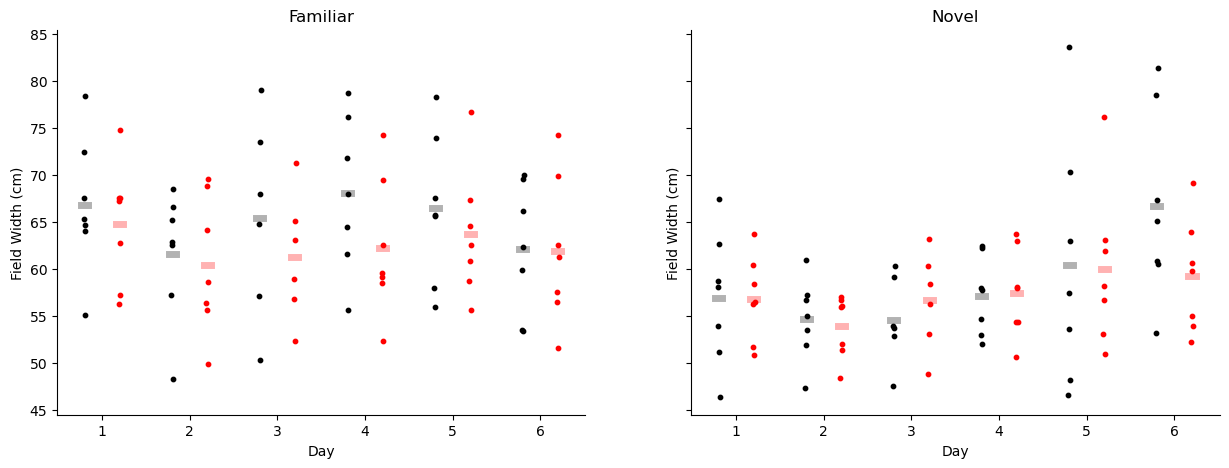

In [225]:
lw = 5
s = 10
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])
    # ax[a].set_yticks(np.arange(40,100, 10))
    # ax[a].set_yticklabels([x for x in range(50,80)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Field Width (cm)')
    ax[a].set_xlabel('Day')

figdir = "C://Users/esay/data/Stx3/fig_scratch/behavior"
fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary.pdf"))

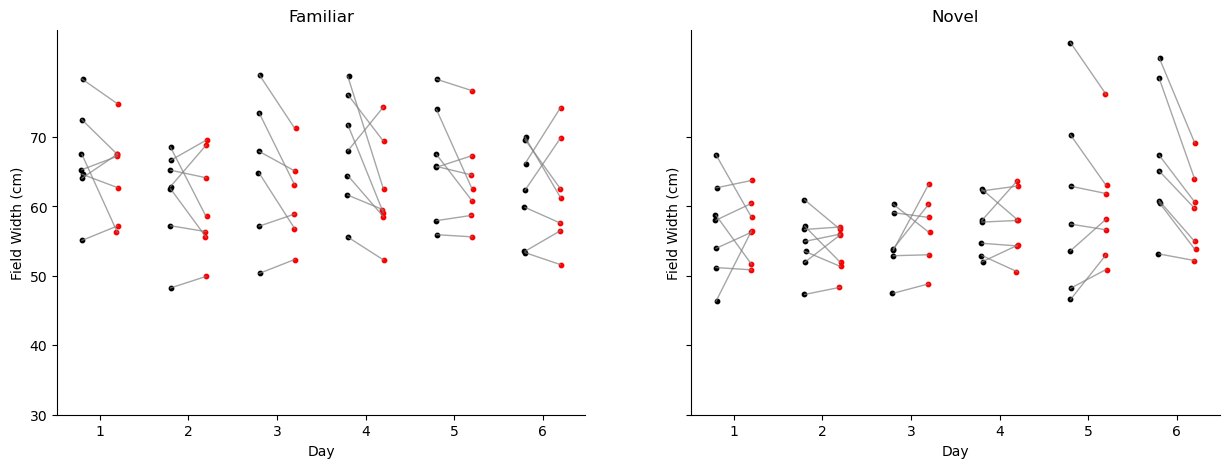

In [177]:
lw = 5
s = 10
fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
# Iterate through days
for day in range(6):
    # Plot ctrl fam (black) and cre fam (red) in Familiar
    mask_ctrl_fam = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'fam')
    mask_cre_fam = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'fam')
    # Extract mouse names and field widths
    ctrl_fam = df.loc[mask_ctrl_fam, ['mouse', 'field_width']].reset_index(drop=True)
    cre_fam = df.loc[mask_cre_fam, ['mouse', 'field_width']].reset_index(drop=True)
    # Plot black and red dots
    ax[0].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_fam)), 10*ctrl_fam['field_width'], color='black', s=s)
    ax[0].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_fam)), 10*cre_fam['field_width'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_fam['mouse']:
        if mouse in cre_fam['mouse'].values:
            y1 = 10 * ctrl_fam.loc[ctrl_fam['mouse'] == mouse, 'field_width'].values[0]
            y2 = 10 * cre_fam.loc[cre_fam['mouse'] == mouse, 'field_width'].values[0]
            ax[0].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
    # Plot ctrl nov (black) and cre nov (red) in Novel
    mask_ctrl_nov = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'nov')
    mask_cre_nov = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'nov')
    ctrl_nov = df.loc[mask_ctrl_nov, ['mouse', 'field_width']].reset_index(drop=True)
    cre_nov = df.loc[mask_cre_nov, ['mouse', 'field_width']].reset_index(drop=True)
    ax[1].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_nov)), 10*ctrl_nov['field_width'], color='black', s=s)
    ax[1].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_nov)), 10*cre_nov['field_width'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_nov['mouse']:
        if mouse in cre_nov['mouse'].values:
            y1 = 10 * ctrl_nov.loc[ctrl_nov['mouse'] == mouse, 'field_width'].values[0]
            y2 = 10 * cre_nov.loc[cre_nov['mouse'] == mouse, 'field_width'].values[0]
            ax[1].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
# Set titles and labels
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
for a in range(2):
    ax[a].set_xticks(np.arange(0, 6*5, 5))
    ax[a].set_xticklabels([x for x in range(1, 7)])
    ax[a].set_yticks(np.arange(30,80, 10))
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_ylabel('Field Width (cm)')
    ax[a].set_xlabel('Day')
# Save figure
figdir = "C://Users/esay/data/Stx3/fig_scratch/behavior"
fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary_with_lines.pdf"))
# plt.show()

In [98]:
lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
lr

[array([], dtype=float64), array([], dtype=float64)]

Text(0.5, 0, 'Day')

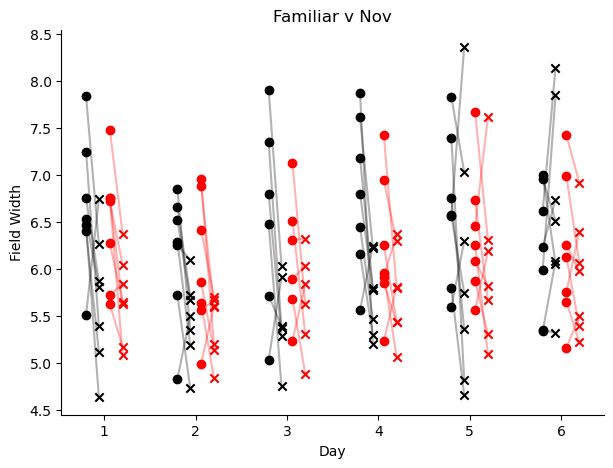

In [152]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    # print(day)
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in sparse_mice:
        # print(mouse)
        if day==2 and mouse=='SparseKO_09':
            continue
        
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in sparse_mice:
        # print(mouse)
        if day==2 and mouse=='SparseKO_09':
            continue
            
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

    
# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Field Width')
ax.set_xlabel('Day')

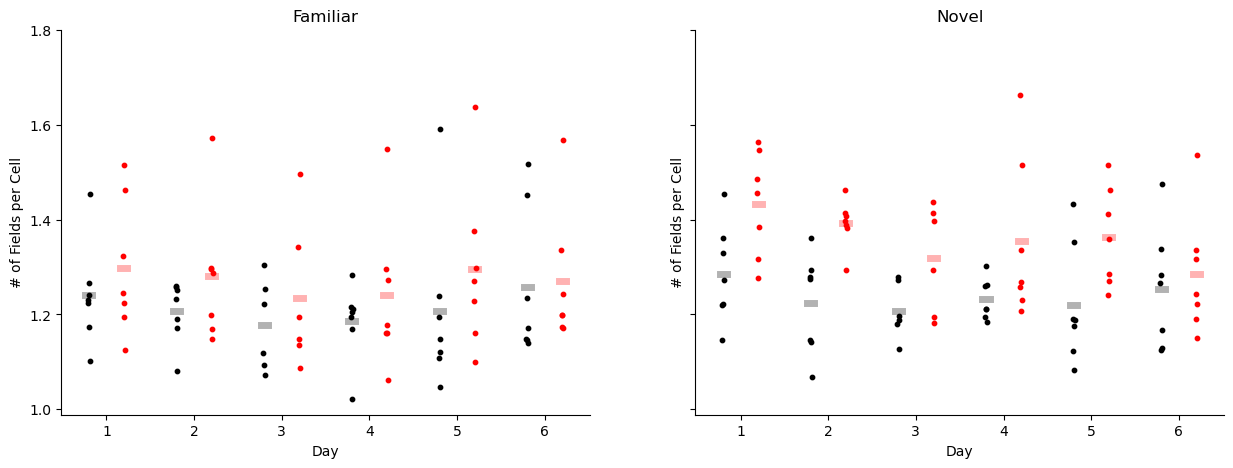

In [21]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)
s = 10
lw = 5
# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])
    ax[a].set_yticks(np.arange(1,2, .2))
    
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('# of Fields per Cell')
    ax[a].set_xlabel('Day')
figdir = 'C:/Users/esay/data/Stx3/YMazeResults'
fig.savefig(os.path.join(figdir, "num_fields_across_mouse_summary.pdf"))


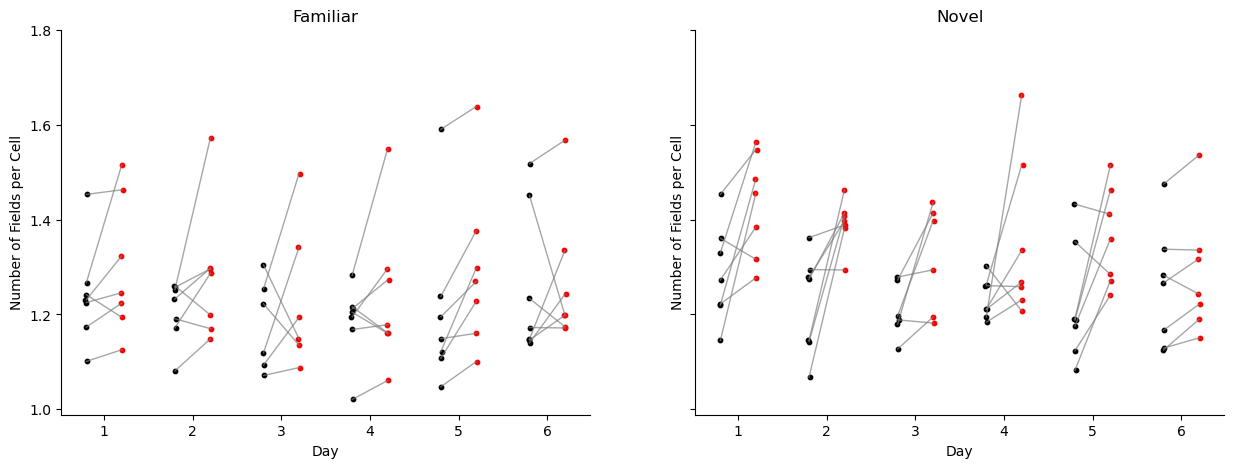

In [155]:
lw = 5
s = 10
fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
for day in range(6):
    # Plot ctrl fam (black) and cre fam (red) in Familiar
    mask_ctrl_fam = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'fam')
    mask_cre_fam = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'fam')
    # Extract mouse names and field widths
    ctrl_fam = df.loc[mask_ctrl_fam, ['mouse', 'n_fields']].reset_index(drop=True)
    cre_fam = df.loc[mask_cre_fam, ['mouse', 'n_fields']].reset_index(drop=True)
    # Plot black and red dots
    ax[0].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_fam)), ctrl_fam['n_fields'], color='black', s=s)
    ax[0].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_fam)), cre_fam['n_fields'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_fam['mouse']:
        if mouse in cre_fam['mouse'].values:
            y1 = ctrl_fam.loc[ctrl_fam['mouse'] == mouse, 'n_fields'].values[0]
            y2 = cre_fam.loc[cre_fam['mouse'] == mouse, 'n_fields'].values[0]
            ax[0].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
    # Plot ctrl nov (black) and cre nov (red) in Novel
    mask_ctrl_nov = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'nov')
    mask_cre_nov = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'nov')
    ctrl_nov = df.loc[mask_ctrl_nov, ['mouse', 'n_fields']].reset_index(drop=True)
    cre_nov = df.loc[mask_cre_nov, ['mouse', 'n_fields']].reset_index(drop=True)
    ax[1].scatter(5*day - 1 + np.linspace(-0.05, 0.05, num=len(ctrl_nov)), ctrl_nov['n_fields'], color='black', s=s)
    ax[1].scatter(5*day + 1 + np.linspace(-0.05, 0.05, num=len(cre_nov)), cre_nov['n_fields'], color='red', s=s)
    # Draw lines between matching mouse names
    for mouse in ctrl_nov['mouse']:
        if mouse in cre_nov['mouse'].values:
            y1 = ctrl_nov.loc[ctrl_nov['mouse'] == mouse, 'n_fields'].values[0]
            y2 = cre_nov.loc[cre_nov['mouse'] == mouse, 'n_fields'].values[0]
            ax[1].plot([5*day - 1, 5*day + 1], [y1, y2], color='gray', linestyle='-', linewidth=1, alpha=0.7)
# Set titles and labels
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
for a in range(2):
    ax[a].set_xticks(np.arange(0, 6*5, 5))
    ax[a].set_xticklabels([x for x in range(1, 7)])
    ax[a].set_yticks(np.arange(1,2, .2))
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_ylabel('Number of Fields per Cell')
    ax[a].set_xlabel('Day')

plt.show()
fig.savefig(os.path.join(figdir, "num_fields_between_mice.pdf"))


[0. 1. 0.]


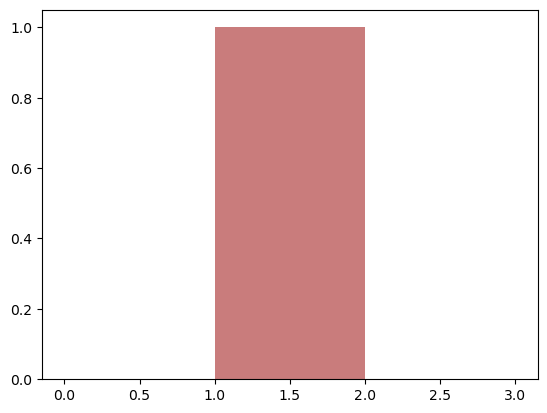

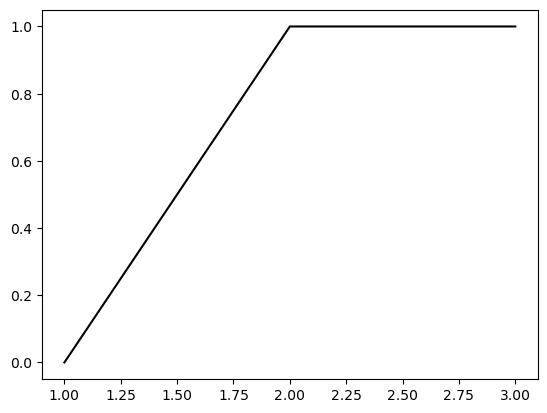

In [14]:
# day 5 histogram

fig, ax = plt.subplots()
fig_cum, ax_cum = plt.subplots()
day = 5

mask_ctrl_fam = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'fam')
mask_cre_fam = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'fam')
# Extract mouse names and field widths
ctrl_fam = df.loc[mask_ctrl_fam, ['mouse', 'n_fields']].reset_index(drop=True)
cre_fam = df.loc[mask_cre_fam, ['mouse', 'n_fields']].reset_index(drop=True)


mask_ctrl_nov = (df['cond'] == 'ctrl') & (df['day'] == day) & (df['ttype'] == 'nov')
mask_cre_nov = (df['cond'] == 'cre') & (df['day'] == day) & (df['ttype'] == 'nov')
ctrl_nov = df.loc[mask_ctrl_nov, ['mouse', 'n_fields']].reset_index(drop=True)
cre_nov = df.loc[mask_cre_nov, ['mouse', 'n_fields']].reset_index(drop=True)

bins = np.arange(0, 4, 1)
hist, bins, _ = ax.hist(ctrl_fam['n_fields'], bins = bins, color='black', alpha = .3, density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color= 'black')


hist, bins, _ = ax.hist(cre_fam['n_fields'], bins = bins, color = 'red', alpha = .3,density=True)
print(hist)


In [92]:
for mouse, days in trial_means.items():
    for day, metrics in days.items():
        for key in list(metrics.keys()):
            if "nov_mean" in key:
                metrics[key.replace("nov_mean","left")] = metrics.pop(key)
            elif "fam_mean" in key:
                metrics[key.replace("fam_mean","right")] = metrics.pop(key)

In [15]:
nov_df = df[df['ttype'] == 'nov']
fam_df = df[df['ttype'] == 'fam']
fam_df, nov_df

(           mouse  cond ttype  day  field_width  n_fields
 1    SparseKO_02   cre   fam    0          5.0       1.0
 3    SparseKO_02  ctrl   fam    0          7.0       1.0
 5    SparseKO_02   cre   fam    1          5.0       1.0
 7    SparseKO_02  ctrl   fam    1          5.0       1.0
 9    SparseKO_02   cre   fam    2          5.0       1.0
 ..           ...   ...   ...  ...          ...       ...
 155  SparseKO_09  ctrl   fam    3          8.0       1.0
 157  SparseKO_09   cre   fam    4          5.0       1.0
 159  SparseKO_09  ctrl   fam    4          7.0       1.0
 161  SparseKO_09   cre   fam    5          5.0       1.0
 163  SparseKO_09  ctrl   fam    5          6.0       1.0
 
 [82 rows x 6 columns],
            mouse  cond ttype  day  field_width  n_fields
 0    SparseKO_02   cre   nov    0          4.0       1.0
 2    SparseKO_02  ctrl   nov    0          5.0       1.0
 4    SparseKO_02   cre   nov    1          4.0       1.0
 6    SparseKO_02  ctrl   nov    1          4.

In [17]:
pg.rm_anova(data=fam_df, dv='field_width', within='cond', subject='mouse', correction='auto', detailed=False, effsize='ng2')


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,cond,1,6,2.802862,0.14512,0.045676,1.0


In [18]:
pg.rm_anova(data=nov_df, dv='field_width', within='cond', subject='mouse', correction='auto', detailed=False, effsize='ng2')


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,cond,1,6,1.145607,0.325626,0.012908,1.0


In [16]:
pg.rm_anova(data=fam_df, dv='n_fields', within='cond', subject='mouse', correction='auto', detailed=False, effsize='ng2')


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,cond,1,6,1.0,0.355918,0.076923,1.0


In [17]:
pg.rm_anova(data=nov_df, dv='n_fields', within='cond', subject='mouse', correction='auto', detailed=False, effsize='ng2')


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,cond,1,6,1.0,0.355918,0.076923,1.0


### permutation test

In [75]:
field_info['SparseKO_02'][0]['channel_0_left']

array([[  1,   1,   9],
       [  5,   1,   7],
       [ 47,   1,  10],
       ...,
       [126,  25,   3],
       [262,  25,   3],
       [307,  25,   3]], dtype=int64)

In [22]:
from scipy.stats import ranksums
def get_metrics(mouse, field_info, metric):
    vals, labels=[],[]
    for day in field_info[mouse].keys():
        for key, arr in field_info[mouse][day].items():
            if arr.size==0:
                continue
            cond = 'cre' if 'channel_0' in key else 'ctrl'
            if metric == 'field_width':
                vals.extend(arr[:,2])
                labels.extend([cond] * arr.shape[0])
            elif metric == 'n_fields':
                for cell in np.unique(arr[:,0]):
                    n_f = np.count_nonzero(arr[:,0]==cell)
                    vals.append(n_f)
                    labels.append(cond)
        return np.array(vals), np.array(labels)

def calc_diff(mouse_data, labels, per_mouse):
    if per_mouse:
        diffs = []
        for m in mouse_data.keys():
            v, l = mouse_data[m]
            if v.size == 0:
                continue
            median_cre = np.median(v[l=='cre']) if np.any(l=='cre') else np.nan
            median_ctrl = np.median(v[l=='ctrl']) if np.any(l=='ctrl') else np.nan
            diffs.append(median_cre - median_ctrl)
        return np.nanmean(diffs)
    else:
        all_v = np.concatenate([mouse_data[m][0] for m in mouse_data])
        all_l = np.concatenate([labels[m] for m in mouse_data])
        median_cre = np.median(all_v[all_l == 'cre'])
        median_ctrl = np.median(all_v[all_l == 'ctrl'])
        return median_cre - median_ctrl

def calc_diff_ranksum(mouse_data, labels, per_mouse):
    if per_mouse:
        stats = []
        for m in mouse_data.keys():
            v, l = mouse_data[m]
            if v.size == 0:
                continue
            v_cre = v[l=='cre']
            v_ctrl= v[l=='ctrl']
            if v_cre.size > 0 and v_ctrl.size > 0:
                s, _ = ranksums(v_cre,v_ctrl)
                stats.append(s)
        return np.nanmean(stats)
    else:
        all_v = np.concatenate([mouse_data[m][0] for m in mouse_data])
        all_l = np.concatenate([labels[m] for m in mouse_data])
        v_cre = all_v[all_l == 'cre']
        v_ctrl = all_v[all_l == 'ctrl']
        s, _ = ranksums(v_cre, v_ctrl)
        return s
        
def permutation_test(field_info, sparse_mice, metric="field_width", n_shuffles=1000, per_mouse=False, seed=0):

    rng = np.random.default_rng(seed)

    mouse_data = {}
    for mouse in sparse_mice:
        print(mouse)
        v, l = get_metrics(mouse, field_info, metric = metric)
        mouse_data[mouse]=(v, l)
        
    # obs_diff = calc_diff(mouse_data, {m: mouse_data[m][1] for m in mouse_data}, per_mouse)
    obs_stats = calc_diff_ranksum(mouse_data, {m: mouse_data[m][1] for m in mouse_data}, per_mouse)
    # permutation
    null_stats = np.zeros(n_shuffles)
    for i in range(n_shuffles):
        shuffled_labels = {}
        for m in mouse_data:
            v, l = mouse_data[m]
            shuffled_labels[m] = rng.permutation(l)
        # null_diffs[i] = calc_diff({m:(mouse_data[m][0], shuffled_labels[m]) for m in mouse_data}, shuffled_labels, per_mouse)
        null_stats[i] = calc_diff_ranksum({m:(mouse_data[m][0], shuffled_labels[m]) for m in mouse_data}, shuffled_labels, per_mouse)
    p_val = np.mean(np.abs(null_stats) >= np.abs(obs_stats))
    return {"obs_stats": obs_stats, "null_stats": null_stats, "p_value": p_val}

In [36]:
def permutation_test(field_info, sparse_mice, metric="field_width", n_shuffles=1000, per_mouse=False, seed=0):

    rng = np.random.default_rng(seed)

    mouse_data = {}
    for mouse in sparse_mice:
        print(mouse)
        v, l = get_metrics(mouse, field_info, metric = metric)
        mouse_data[mouse]=(v, l)
        
    # obs_diff = calc_diff(mouse_data, {m: mouse_data[m][1] for m in mouse_data}, per_mouse)
    obs_stats = calc_diff_ranksum(mouse_data, {m: mouse_data[m][1] for m in mouse_data}, per_mouse)
    # permutation
    null_stats = np.zeros(n_shuffles)
    for i in range(n_shuffles):
        shuffled_labels = {}
        for m in mouse_data:
            v, l = mouse_data[m]
            shuffled_labels[m] = rng.permutation(l)
        # null_diffs[i] = calc_diff({m:(mouse_data[m][0], shuffled_labels[m]) for m in mouse_data}, shuffled_labels, per_mouse)
        null_stats[i] = calc_diff_ranksum({m:(mouse_data[m][0], shuffled_labels[m]) for m in mouse_data}, shuffled_labels, per_mouse)
    p_val = np.mean(np.abs(null_stats) >= np.abs(obs_stats))
    return {"obs_stats": obs_stats, "null_stats": null_stats, "p_value": p_val}


In [23]:
results = permutation_test(field_info, sparse_mice, 'n_fields', per_mouse = True)

SparseKO_02
SparseKO_06
SparseKO_08
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_09


In [24]:
results

{'obs_stats': 1.4659404293769338,
 'null_stats': array([-2.31265554e-01, -1.94376517e-01, -2.65630488e-01,  5.80649339e-01,
         1.33588994e-01, -3.49417147e-01, -3.99634956e-01, -2.51029908e-02,
         4.64274445e-01,  2.97466709e-01, -6.47954101e-01,  6.45447331e-01,
         3.02218689e-02,  1.80183712e-01,  1.53585085e-01, -1.64355111e-01,
         1.86223276e-01,  1.74320390e-01, -3.59692020e-01,  1.06575254e-01,
        -2.15066218e-01, -1.61031428e-01, -3.38353897e-01,  1.04534466e-01,
         4.27603906e-02, -4.92253882e-01, -1.30302648e-01,  1.81247402e-01,
         4.32702799e-02, -2.10551397e-01, -2.14604264e-01, -2.50594099e-01,
         1.59100100e-03,  9.97475961e-02,  4.06326975e-01, -1.45399889e-03,
        -1.30788852e-01, -8.53026354e-01, -8.52352558e-02, -3.55741852e-02,
        -6.59968173e-02, -1.74725463e-01, -2.10493057e-01, -1.72872559e-01,
        -2.22394768e-01,  7.52226718e-01, -4.07908607e-01, -4.39761115e-02,
        -4.08357253e-01,  3.00177569e-01

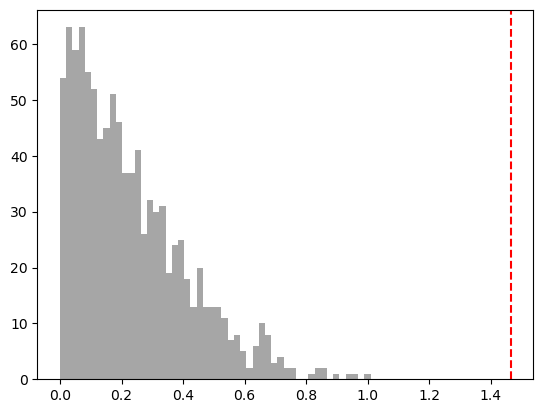

In [25]:
plt.hist(np.abs(results['null_stats']), bins=50, alpha=0.7, color='gray')
plt.axvline(np.abs(results['obs_stats']), color = 'red', linestyle='--')
plt.savefig(os.path.join(figdir, "num_fields_perm_test.pdf"))


### try binning speed

In [52]:
_res = np.load("C:/Users/esay/data/Stx3/sparse_analyses/sig_fields/place_field_stats_dff_with09.npy", allow_pickle=True).all()
# _res = np.load("./place_field_stats_spks_smooth.npy", allow_pickle=True).all()

ko_field_mask_res, ctrl_field_mask_res = _res['ko'], _res['ctrl']


In [88]:
df_shifts = pd.read_pickle("C:/Users/esay/data/Stx3/sparse_analyses/sig_fields/df_shifts_dff_alldays.pkl")

,ko,day,nov,fw,mouse,ko_x_day,ko_x_nov,nov_x_day,speed,intercept
0,1,0.166667,0,3,SparseKO_02,0.166667,0,0.000000,0.078926,1
1,1,0.166667,0,1,SparseKO_02,0.166667,0,0.000000,0.010407,1
2,1,0.166667,0,8,SparseKO_02,0.166667,0,0.000000,0.056921,1
3,1,0.166667,0,3,SparseKO_02,0.166667,0,0.000000,NaN,1
4,1,0.166667,0,8,SparseKO_02,0.166667,0,0.000000,0.065362,1
...,...,...,...,...,...,...,...,...,...,...
15086,0,0.833333,1,3,SparseKO_09,0.000000,0,0.833333,0.101339,1
15087,0,0.833333,1,6,SparseKO_09,0.000000,0,0.833333,0.201418,1
15088,0,0.833333,1,3,SparseKO_09,0.000000,0,0.833333,0.155179,1
15089,0,0.833333,1,16,SparseKO_09,0.000000,0,0.833333,0.164160,1


In [150]:
import numpy as np
import scipy.stats as sp
import pandas as pd

def permutation_test_speed_binned(df, key = 'width', n_shuffles=1000, n_bins=5, alpha=0.05):

    # if 'speed' entries are arrays, reduce to mean
    speed_vals = df['speed']
    bins = np.quantile(speed_vals.dropna(), np.linspace(0, 1, n_bins+1))
    
    def get_stat(df):
        stat_sum = 0
        for b in range(n_bins):
            c_bin = df[(df['ko']==0) & (df['speed']>=bins[b]) & (df['speed']<bins[b+1])]
            k_bin = df[(df['ko']==1) & (df['speed']>=bins[b]) & (df['speed']<bins[b+1])]
            if len(c_bin) > 0 and len(k_bin) > 0:
                stat, _ = sp.ranksums(c_bin['width'], k_bin['width'])
                stat_sum += stat
        return stat_sum
    
    observed_sum = get_stat(df)

    null_sums = []
    mice = df['mouse'].unique()
    for _ in range(n_shuffles):
        shuffled_df = df.copy()
        shuffled_labels = []
        # shuffle ko labels within each mouse
        for m in mice:
            mouse_mask = shuffled_df['mouse'] == m
            mouse_labels = shuffled_df.loc[mouse_mask, 'ko'].values
            shuffled_df.loc[mouse_mask, 'ko'] = np.random.permutation(mouse_labels)
        # compute summed stat after shuffling
        shuffled_stats = get_stat(shuffled_df)
        null_sums.append(shuffled_stats)
    null_sums = np.array(null_sums)
    
    p_value_sum = (np.sum(np.abs(null_sums) >= np.abs(observed_sum)) + 1) / (n_shuffles + 1)

    '''
    checking per bin differences
    '''
    bin_rows = []
    for b in range(n_bins):
        c_bin = df[(df['ko']==0) & (df['speed']>=bins[b]) & (df['speed']<bins[b+1])]
        k_bin = df[(df['ko']==1) & (df['speed']>=bins[b]) & (df['speed']<bins[b+1])]
        if len(c_bin) > 0 and len(k_bin) > 0:
            stat, pval = ranksums(c_bin['width'], k_bin['width'])
            bin_rows.append({
                "bin": b,
                "bin_range": (bins[b], bins[b+1]),
                "ctrl_n": len(c_bin),
                "ko_n": len(k_bin),
                "stat": stat,
                "pval": pval,
                "significant": pval < alpha
            })
        else:
            bin_rows.append({
                "bin": b,
                "bin_range": (bins[b], bins[b+1]),
                "ctrl_n": len(c_bin),
                "ko_n": len(k_bin),
                "stat": np.nan,
                "pval": np.nan,
                "significant": False
            })
    
    bin_results = pd.DataFrame(bin_rows)

    return observed_sum, p_value_sum, null_sums#, bin_results, bins,


In [151]:
observed_sum, p_value_sum, null_sums = permutation_test_speed_binned(df_shifts)
observed_sum, p_value_sum, null_sums

(30.921427866616007,
 0.000999000999000999,
 array([-1.22314708e+00, -2.16822674e+00, -6.10308106e+00, -3.15134352e+00,
        -5.13280323e+00, -3.46834662e-01, -4.19065108e+00, -1.92347264e+00,
        -2.79813987e+00,  1.37827070e+00,  6.10270002e-01, -1.28409441e-01,
        -5.72645201e-01, -4.70975464e+00, -2.34419585e+00,  2.56269277e+00,
        -2.22487202e+00,  5.61754387e-01, -3.96147690e+00, -2.29225428e-01,
        -6.75722821e+00, -2.99481964e+00,  1.69404273e+00, -1.53902027e+00,
         2.47888304e+00, -1.54231044e+00, -6.03277058e+00, -3.00755746e+00,
        -7.23199649e-02, -2.69980152e+00,  1.01125343e-01, -9.13098440e-01,
        -6.90165744e-01, -2.59917379e+00, -4.10646250e+00,  1.07860227e+00,
        -3.15606907e+00, -1.22517409e+00, -2.34617573e+00, -1.87092204e+00,
         5.24857269e-01, -2.89637053e+00, -1.06253271e+00, -5.35305292e-01,
        -5.82468842e+00, -5.25776853e+00, -2.97217804e+00, -2.49692814e+00,
        -3.58870862e+00, -2.44855360e-01, -8

In [152]:
bin_results

,bin,bin_range,ctrl_n,ko_n,stat,pval,significant
0,0,"(0.007583870208898285, 0.0544530801427756)",613,2006,3.057457,2.232238e-03,True
1,1,"(0.0544530801427756, 0.08032743253125371)",647,1972,7.123035,1.055758e-12,True
2,2,"(0.08032743253125371, 0.11461050649889)",700,1917,9.824860,8.799649e-23,True
3,3,"(0.11461050649889, 0.15103701540176986)",704,1916,8.006923,1.176143e-15,True
4,4,"(0.15103701540176986, 0.315373766148001)",808,1810,4.569573,4.887198e-06,True


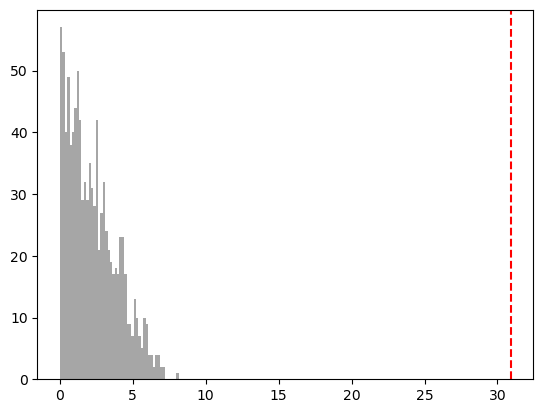

In [153]:
plt.hist(np.abs(null_sums), bins=50, alpha=0.7, color='gray')
plt.axvline(np.abs(observed_sum), color = 'red', linestyle='--')

### field shift analysis

In [27]:
df_shifts = pd.read_pickle("C:/Users/esay/data/Stx3/sparse_analyses/sig_fields/df_shifts_dff_alldays.pkl")

C:\Users\esay\AppData\Local\Temp\ipykernel_210852\2646567249.py:9: RuntimeWarning: Mean of empty slice
  plot_arr[0,0,m,day]=np.nanmean(10*shifts)
C:\Users\esay\AppData\Local\Temp\ipykernel_210852\2646567249.py:17: RuntimeWarning: Mean of empty slice
  plot_arr[1,0,m,day]=np.nanmean(10*shifts)
C:\Users\esay\AppData\Local\Temp\ipykernel_210852\2646567249.py:26: RuntimeWarning: Mean of empty slice
  plot_arr[0,1,m,day]=np.nanmean(10*shifts)
C:\Users\esay\AppData\Local\Temp\ipykernel_210852\2646567249.py:34: RuntimeWarning: Mean of empty slice
  plot_arr[1,1,m,day]=np.nanmean(10*shifts)


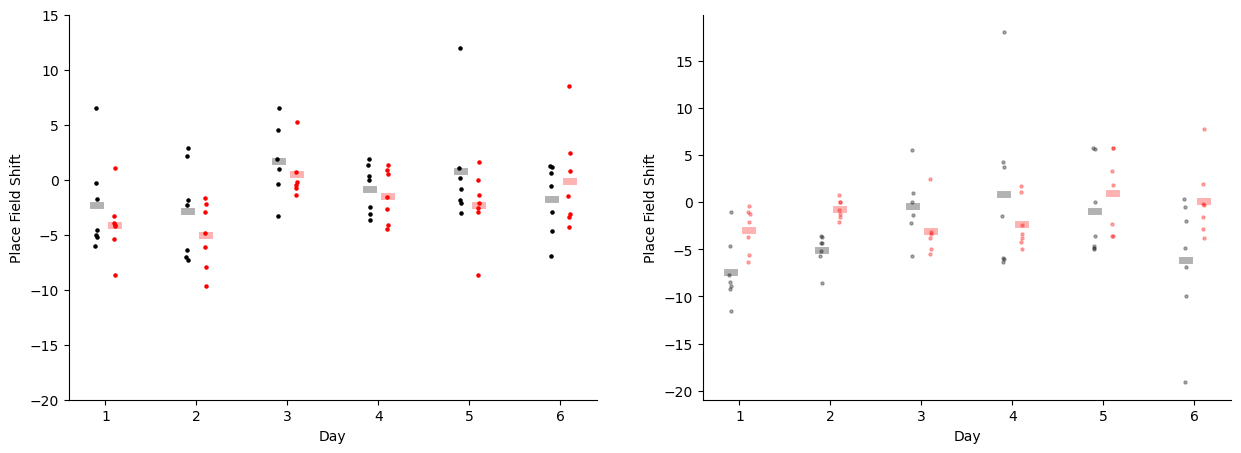

In [38]:
fig, ax = plt.subplots(1,2, figsize = [15,5], sharey=False)

plot_arr = np.zeros([2, 2, 7, 6 ])
for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0) # & (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]._values.ravel()
        plot_arr[0,0,m,day]=np.nanmean(10*shifts)
        

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(10*shifts)
#         ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(10*shifts)
#         ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(10*shifts)
#         ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)


    
for day in range(6):
    
    
    ax[0].scatter(5*day - .5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[0,0,:,day], color = 'black', s = 5 )
    ax[0].plot(5*day -.5 + np.array([-.2,.2]), np.nanmean(plot_arr[0,0,:,day])*np.ones([2,]), color = 'black', linewidth=5, alpha = .3)
#     ax.bar([day-.275], [np.nanmean(plot_arr[0,0,:,day])],yerr = [sp.stats.sem(plot_arr[0,0,:,day], nan_policy='omit')],width = .15, edgecolor='black', fill=False)
    
    ax[1].scatter(5*day -.5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[0,1,:,day], color = 'black', s = 5 , alpha = .3)
    ax[1].plot(5*day -.5 + np.array([-.2,.2]), np.nanmean(plot_arr[0,1,:,day])*np.ones([2,]), color = 'black', linewidth=5, alpha = .3)
#     ax.bar([day-.075], [np.nanmean(plot_arr[0,0,:,day])],yerr = [sp.stats.sem(plot_arr[0,1,:,day], nan_policy='omit')],width = .15, edgecolor='black',alpha = .3, fill=False)
    
    ax[0].scatter(5*day + .5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[1,0,:,day], color = 'red', s = 5 )
    ax[0].plot(5*day +.5 + np.array([-.2,.2]), np.nanmean(plot_arr[1,0,:,day])*np.ones([2,]), color = 'red', linewidth=5, alpha = .3)
#     ax.bar([day+.125], [np.nanmean(plot_arr[1,0,:,day])],yerr = [sp.stats.sem(plot_arr[1,0,:,day], nan_policy='omit')],width = .15, edgecolor='red',alpha = 1, fill=False)
    
    
    ax[1].scatter(5*day +.5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[1,1,:,day], color = 'red', s = 5 , alpha = .3)
    ax[1].plot(5*day +.5 + np.array([-.2,.2]), np.nanmean(plot_arr[1,1,:,day])*np.ones([2,]), color = 'red', linewidth=5, alpha = .3)
#     ax.bar([day+.325], [np.nanmean(plot_arr[1,1,:,day])],yerr = [sp.stats.sem(plot_arr[1,1,:,day], nan_policy='omit')],width = .15, edgecolor='red',alpha = .3, fill=False)
    
    
# ax.set_xticks(10*np.arange(6)+2)
# ax.set_xticklabels(np.arange(6))
for a in range(2):
    ax[a].set_xlabel('Day')
    ax[a].set_ylabel('Place Field Shift')
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xticks(np.arange(0,26,5))
    ax[a].set_xticklabels(np.arange(1,7))
    ax[a].set_yticks(np.arange(-20,20,5))
# fig.savefig(os.path.join(figdir, "field_shift_summary.pdf"))

C:\Users\esay\AppData\Local\Temp\ipykernel_210852\2445352065.py:12: RuntimeWarning: Mean of empty slice
  plot_arr[0,0,m,day]=np.nanmean(10*shifts)
C:\Users\esay\AppData\Local\Temp\ipykernel_210852\2445352065.py:22: RuntimeWarning: Mean of empty slice
  plot_arr[0,1,m,day]=np.nanmean(10*shifts)


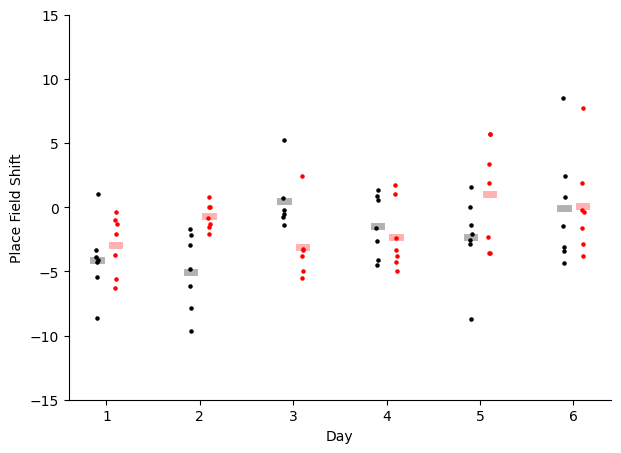

In [46]:
fig, ax = plt.subplots(1,1, figsize = [7,5], sharey=False)

plot_arr = np.zeros([2, 2, 7, 6 ])

        

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(10*shifts)
#         ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        

for m, mouse in enumerate(sparse_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)#& (df_shifts['init_speed']>.05)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(10*shifts)
#         ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)


    
for day in range(6):
    
    

    
    ax.scatter(5*day -.5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[0,0,:,day], color = 'black', s = 5 )#, alpha = .3)
    ax.plot(5*day -.5 + np.array([-.2,.2]), np.nanmean(plot_arr[0,0,:,day])*np.ones([2,]), color = 'black', linewidth=5, alpha = .3)
#     ax.bar([day-.075], [np.nanmean(plot_arr[0,0,:,day])],yerr = [sp.stats.sem(plot_arr[0,1,:,day], nan_policy='omit')],width = .15, edgecolor='black',alpha = .3, fill=False)
    

    
    ax.scatter(5*day +.5 + np.linspace(-0.05,.05, num = plot_arr.shape[2]), plot_arr[0,1,:,day], color = 'red', s = 5)# , alpha = .3)
    ax.plot(5*day +.5 + np.array([-.2,.2]), np.nanmean(plot_arr[0,1,:,day])*np.ones([2,]), color = 'red', linewidth=5, alpha = .3)
#     ax.bar([day+.325], [np.nanmean(plot_arr[1,1,:,day])],yerr = [sp.stats.sem(plot_arr[1,1,:,day], nan_policy='omit')],width = .15, edgecolor='red',alpha = .3, fill=False)
    
    
# ax.set_xticks(10*np.arange(6)+2)
# ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Shift')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0,26,5))
ax.set_xticklabels(np.arange(1,7))
ax.set_yticks(np.arange(-15,20,5))
fig.savefig(os.path.join(figdir, "nov_arm_field_shift_summary.pdf"))

C:\Users\esay\AppData\Local\Temp\ipykernel_179892\2960794232.py:34: DeprecationWarning: Please import `linregress` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  res = sp.stats.linregress(ctrl_df['init_speed_cm_s'], ctrl_df['width_cm'])
C:\Users\esay\AppData\Local\Temp\ipykernel_179892\2960794232.py:39: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  r, p = sp.stats.spearmanr(ctrl_df['init_speed_cm_s'], ctrl_df['width_cm'])


Ctrl: slope: 1.3329177121678368 intercept: 43.84371399935253
Spearman r: 0.3135149698138939 p: 6.431263983450748e-55


C:\Users\esay\AppData\Local\Temp\ipykernel_179892\2960794232.py:61: DeprecationWarning: Please import `linregress` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  res = sp.stats.linregress(ko_df['init_speed_cm_s'], ko_df['width_cm'])
C:\Users\esay\AppData\Local\Temp\ipykernel_179892\2960794232.py:66: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  r, p = sp.stats.spearmanr(ko_df['init_speed_cm_s'], ko_df['width_cm'])


KO: slope: 1.3801942264722642 intercept: 33.65257067207038
Spearman r: 0.4133079325768005 p: 2.2464126046204821e-175


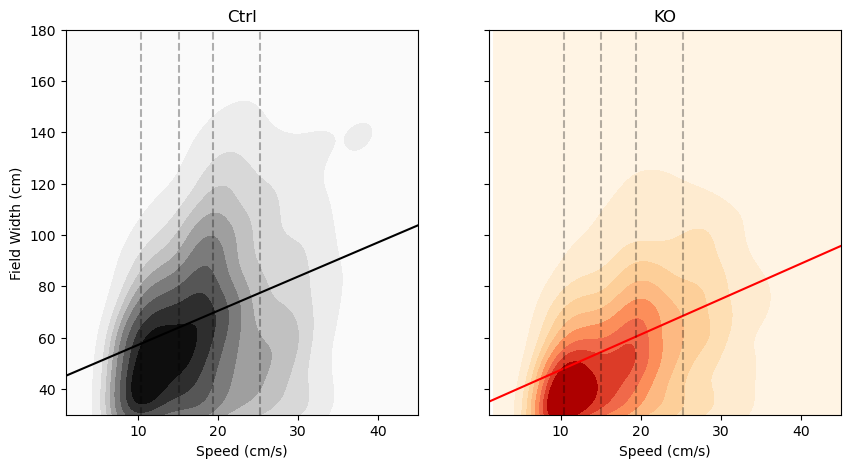

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp

fig, ax = plt.subplots(1, 2, figsize=[10, 5], sharey=True, sharex=True)

# Convert units: speed in cm/s (init_speed * 15.46 * 10), width in cm (width * 10)
ctrl_df = df_shifts[(df_shifts['ko'] == 0) & (df_shifts['speed'] > 0.05)].copy() # & (df_shifts['day'] == 0)
ctrl_df['init_speed_cm_s'] = ctrl_df['speed'] * 15.46 * 10
# ctrl_df['init_speed_cm_s'] = ctrl_df['init_speed'] * 15.46 * 10
ctrl_df['width_cm'] = ctrl_df['width'] * 10
# ctrl_df['shift_cm'] = ctrl_df['width'] * 10

all_speeds = df_shifts['speed']
n_bins = 5
speed_bins = np.quantile(all_speeds[~np.isnan(all_speeds)], np.linspace(0, 1, n_bins+1))
# convert to cm/s
speed_bins_cm = speed_bins * 15.46 * 10

# Seaborn KDE contour
sns.kdeplot(
    data=ctrl_df,
    x='init_speed_cm_s',
    y='width_cm',
    ax=ax[0],
    cmap='Greys',
    fill=True,
    levels=10,
    thresh=0,
)

# Regression line
res = sp.stats.linregress(ctrl_df['init_speed_cm_s'], ctrl_df['width_cm'])
x = np.linspace(0, 45)
ax[0].plot(x, res.slope * x + res.intercept, color='black')

# Correlation
r, p = sp.stats.spearmanr(ctrl_df['init_speed_cm_s'], ctrl_df['width_cm'])
print('Ctrl:', 'slope:', res.slope, 'intercept:', res.intercept)
print('Spearman r:', r, 'p:', p)

# KO group
ko_df = df_shifts[(df_shifts['ko'] == 1)  & (df_shifts['speed'] > 0.05)].copy() #& (df_shifts['day'] == 0)
ko_df['init_speed_cm_s'] = ko_df['speed'] * 15.46 * 10
# ko_df['init_speed_cm_s'] = ko_df['init_speed'] * 15.46 * 10
ko_df['width_cm'] = ko_df['width'] * 10

sns.kdeplot(
    data=ko_df,
    x='init_speed_cm_s',
    y='width_cm',
    ax=ax[1],
    cmap='OrRd',
    fill=True,
    levels=10,
    thresh=0,
)

# Regression line
res = sp.stats.linregress(ko_df['init_speed_cm_s'], ko_df['width_cm'])
x = np.linspace(0, 45)
ax[1].plot(x, res.slope * x + res.intercept, color='red')

# Correlation
r, p = sp.stats.spearmanr(ko_df['init_speed_cm_s'], ko_df['width_cm'])
print('KO:', 'slope:', res.slope, 'intercept:', res.intercept)
print('Spearman r:', r, 'p:', p)

# Labels
ax[0].set_title('Ctrl')
ax[1].set_title('KO')
ax[0].set_xlabel('Speed (cm/s)')
ax[1].set_xlabel('Speed (cm/s)')
ax[0].set_ylabel('Field Width (cm)')

# Optional: set same axis limits for comparison
ax[0].set_xlim(1, 45)
ax[0].set_ylim(30, 180)

for b in speed_bins_cm[1:-1]:  # skip first and last edges
    for axis in ax:
        axis.axvline(b, linestyle="--", color="k", alpha=0.3)

# Optional save
figdir = 'C:/Users/esay/data/Stx3/YMazeResults/neural'
fig.savefig(os.path.join(figdir,"speed_vs_width_2dhist.pdf"))


(array([0.04674291, 0.03331676, 0.0313277 , 0.03480855, 0.03232223,
        0.03530582, 0.03530582, 0.02734958, 0.02685231, 0.0298359 ,
        0.03083043, 0.03381402, 0.04475385, 0.04425659, 0.05022377,
        0.03878667, 0.03630035, 0.02585778, 0.0198906 , 0.03331676,
        0.0298359 , 0.02436599, 0.01740428, 0.02088513, 0.01690701,
        0.01491795, 0.0198906 , 0.0213824 , 0.01392342, 0.01243163,
        0.01541522, 0.0099453 , 0.00646445, 0.00845351, 0.00546992,
        0.00298359, 0.00497265, 0.0099453 , 0.0099453 , 0.00696171,
        0.00596718, 0.00397812, 0.00298359, 0.00447539, 0.00348086,
        0.00646445, 0.00248633, 0.00397812, 0.        , 0.00248633]),
 array([ 7.74688712,  8.52148789,  9.29608866, 10.07068943, 10.84529021,
        11.61989098, 12.39449175, 13.16909252, 13.9436933 , 14.71829407,
        15.49289484, 16.26749561, 17.04209639, 17.81669716, 18.59129793,
        19.3658987 , 20.14049948, 20.91510025, 21.68970102, 22.46430179,
        23.23890256, 24.01

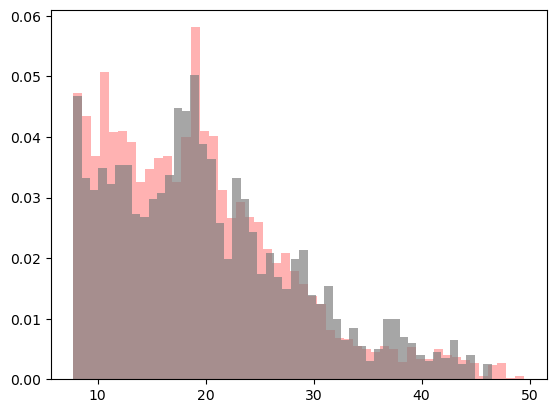

In [132]:
# checking for speed distribution differences
n_ko = len(ko_df)
n_ctrl = len(ctrl_df)

plt.hist(ko_df['init_speed_cm_s'], bins=50, alpha=0.3, color='red', weights=np.ones(n_ko)/n_ko)
plt.hist(ctrl_df['init_speed_cm_s'], bins=50, alpha=0.7, color='gray', weights=np.ones(n_ctrl)/n_ctrl)


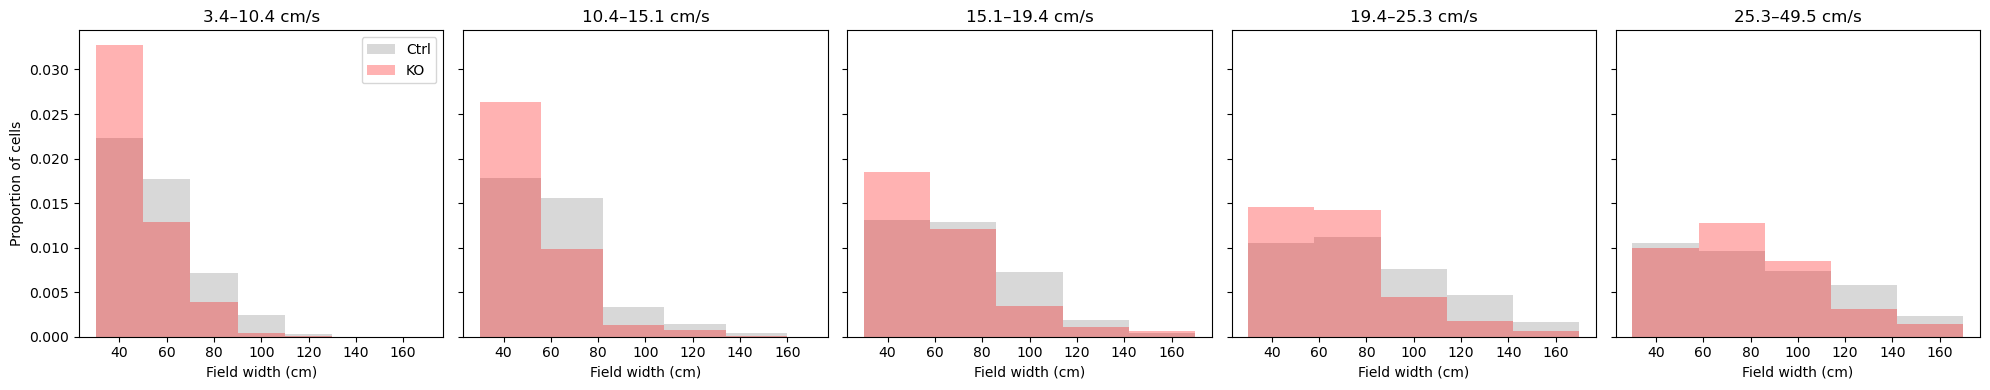

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Define bins exactly as in the shuffle
all_speeds = df_shifts['speed']
n_bins = 5
bins_ = np.quantile(all_speeds.dropna(), np.linspace(0, 1, n_bins+1))
# np.quantile(all_speeds[~np.isnan(all_speeds)], np.linspace(0, 1, n_bins+1))
# speed_vals = df['speed']
# bins = np.quantile(speed_vals.dropna(), np.linspace(0, 1, n_bins+1))

# Convert units
df_shifts = df_shifts.copy()
df_shifts['init_speed_cm_s'] = df_shifts['speed'] * 15.46 * 10
df_shifts['width_cm'] = df_shifts['width'] * 10

ctrl_df = df_shifts[(df_shifts['ko'] == 0) & (df_shifts['speed'] > 0.05)]
ko_df   = df_shifts[(df_shifts['ko'] == 1) & (df_shifts['speed'] > 0.05)]

# Normalize histograms by group size
n_ctrl = len(ctrl_df)
n_ko = len(ko_df)

# Plot per speed bin
fig, axes = plt.subplots(1, n_bins, figsize=(4*n_bins, 4), sharey=True, sharex=True)

for i in range(n_bins):
    lo, hi = bins_[i], bins_[i+1]

    # select data in this speed bin
    ctrl_bin = ctrl_df[(ctrl_df['speed'] >= lo) & (ctrl_df['speed'] < hi)]
    ko_bin   = ko_df[(ko_df['speed'] >= lo) & (ko_df['speed'] < hi)]

    ax = axes[i]
    all_widths = np.concatenate([ctrl_bin['width_cm'].values,
                             ko_bin['width_cm'].values])
    bin_edges = np.linspace(all_widths.min(), all_widths.max(), 6)  # 5 bins → 6 edges
    
    ax.hist(ctrl_bin['width_cm'], bins=bin_edges, alpha=0.3, color='gray',
        density=True, label='Ctrl')
    ax.hist(ko_bin['width_cm'], bins=bin_edges, alpha=0.3, color='red',
        density=True, label='KO')
    # ax.hist(ctrl_bin['width_cm'], bins=5, alpha=0.3, color='gray',
    #         density = True, label='Ctrl')
    # ax.hist(ko_bin['width_cm'], bins=5, alpha=0.3, color='red',
    #         density = True, label='KO')

    ax.set_title(f"{lo*15.46*10:.1f}–{hi*15.46*10:.1f} cm/s")
    if i == 0:
        ax.set_ylabel("Proportion of cells")
    ax.set_xlabel("Field width (cm)")

axes[0].legend()
fig.tight_layout()

# Optional save
figdir = "C:/Users/esay/data/Stx3/YMazeResults/neural"
fig.savefig(os.path.join(figdir,"field_width_hist_by_speedbin.pdf"))
plt.show()
